### Steps for clustering algorithm (what has been done manually and now needs to be automated)

1. Seasonality : 4 hour window periods
2. Standard deviation for 4 hour periods
3. Timestamps matched for carbohydrate intake (i.e. all 35g CHO within 1 hour of eachother grouped together)
4. Rate of glucose appearance and disappearance<br>
    *a. Glucose excursion (nadir to peak / peak to nadir) - +ve and -ve trends*<br>
    *b. iAUC (nadir to peak / peak to nadir) - +ve and -ve trends*
5. Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 
6. Incude the Carbs consumed in the 4 hour period
7. Collate the results of the above points into a data set with columns names:
    * Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)  
    * Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
    * Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
    * Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
    * Time period Number (1 / 2 / 3 / 4 / 5)
    * iAUC (+ve)
    * iAUC (-ve)
    * Glucose Excursion (+ve)
    * Glucose Excursion (-ve)
    * Total change in BG (+ve)
    * Total change in BG (-ve)
    * Peak value
    * Carbs
8. Run Clustering Algorithm
9. Goodness of fit assessment :
    * Want the algorithm to be adaptive.
    * Have the left overs recycled through the 'rules' missing the glucose excursion but maintaining the iAUC and total change in BG.
    * Then further iterations miss out the iAUC and review total change in BG etc

First things first:
Import/load necessary libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import datetime
import calendar
import time
from datetime import timedelta
from statistics import mode
from scipy.signal import find_peaks

%matplotlib inline

Load and preprocess necessary data sets

In [2]:
def read_data(filename):
    unfiltered = pd.read_csv(os.path.join("CSV Files", filename))
    unfiltered['glucose_level_ts'] = pd.to_datetime(unfiltered['glucose_level_ts'])
    unfiltered.drop('glucose_level_mmol/L', axis=1, inplace=True)
    return unfiltered

In [3]:
def slice_data(data, time_step, n_samples):
    timestamp = np.array(data['glucose_level_ts'], dtype=float)
    glucose = np.array(data['glucose_level_mg/dL'], dtype=float)
    n_samples_per_segment = int(time_step / timedelta(minutes=1)) * n_samples
    glucose_seg_ts = [timestamp[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    glucose_sliced = [glucose[i:i + n_samples_per_segment] for i in range(0, len(data), n_samples_per_segment)]
    return glucose_sliced, glucose_seg_ts

In [4]:
unfiltered = read_data('544_data.csv')

In [5]:
# Select glucose level and timestamp features
features = ['glucose_level_ts', 'glucose_level_mg/dL']
data = unfiltered[features].copy()

# Map day of week names to day of week numbers
data['day_of_week'] = data['glucose_level_ts'].dt.dayofweek
data['day_of_week_name'] = data['glucose_level_ts'].dt.day_name()

# Set time step in minutes
time_step = data['glucose_level_ts'].diff().mode()[0] / timedelta(minutes=1)

# Calculate rate of change
data['BG Rate of Change'] = data['glucose_level_mg/dL'].diff() / time_step
data['bg_rate_of_change'] = data['glucose_level_mg/dL'].diff() / time_step

# Convert datetime values to numeric values
data['glucose_level_ts'] = pd.to_datetime(data['glucose_level_ts']).astype(int) // 10**9


In [6]:
# Set time threshold values for glycemic events
max_nadir_to_peak_time = datetime.timedelta(hours=2)
max_peak_to_2nd_nadir_time = datetime.timedelta(hours=4)
max_peak_to_peak_time = datetime.timedelta(hours=6)

# Convert time threshold values to seconds
max_nadir_to_peak_time_sec = max_nadir_to_peak_time.total_seconds()
max_peak_to_2nd_nadir_time_sec = max_peak_to_2nd_nadir_time.total_seconds()

prominence = 18 

Step 2:

Isolate the peak and nadir (low) points in the set windows

In [7]:
# sliced data set into 4 hour segments
timestamp = np.array(data['glucose_level_ts'], dtype=float)
glucose = np.array(data['glucose_level_mg/dL'], dtype=float)
elements_per_6hours = 72  # 72 BG samples in 6 hours sample
glucose_seg_ts = [timestamp[i:i+elements_per_6hours] for i in range(0, len(data), elements_per_6hours)]
glucose_sliced = [glucose[i:i+elements_per_6hours] for i in range(0, len(data), elements_per_6hours)]

glucose_segment = glucose_sliced[1] #selecting the 3rd segment, for example
glucose_segment_ts = glucose_seg_ts[1] 

prominence = 3.6*5 # mg/dL

# Add in Thresholds

print("Length of glucose segment:", len(glucose_segment))

# find peaks and troughs
peaks, _ = find_peaks(glucose_segment)
troughs, _ = find_peaks(-glucose_segment)

# Print peaks and troughs
print("Peaks: ", peaks)
print("Troughs: ", troughs)

# Check the length of the peaks and troughs lists
print("Length of peaks:", len(peaks))
print("Length of troughs:", len(troughs))

Length of glucose segment: 72
Peaks:  [ 4  7 53 56 67]
Troughs:  [ 5 33 54 61]
Length of peaks: 5
Length of troughs: 4


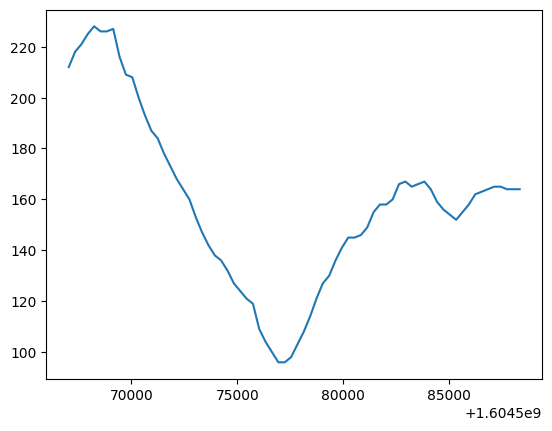

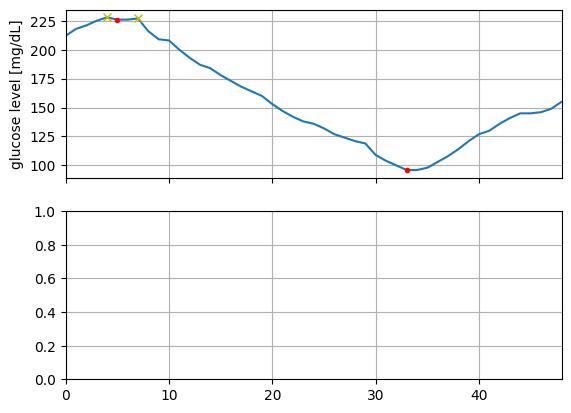

In [9]:
plt.plot(glucose_segment_ts, glucose_sliced[1])

_, ax = plt.subplots(2, sharex=True)
for j in [0,1]: ax[j].grid()

window_days = 1
offset = 0 # days from start (change this to look at other weeks)

ax[0].plot(glucose_sliced[1])
ax[0].plot(peaks, glucose_segment[peaks], "yx")
ax[0].plot(troughs, glucose_segment[troughs], "r.")
ax[0].set_ylabel('glucose level [mg/dL]')
ax[0].set_xlim(offset*(4*60/5), (offset+window_days)*4*60/5)

plt.show()

Isolate the Glucose Events (initial low, peak and secondary low)

In [8]:
print(f"Before loop: glucose_segment={glucose_segment.shape}")

# Set time threshold values for glycemic events
max_nadir_to_peak_time = timedelta(hours=2)
max_peak_to_2nd_nadir_time = timedelta(hours=4)
max_peak_to_peak_time = timedelta(hours=6)

events = []
for i in range(len(glucose_sliced)):
    glucose_segment = glucose_sliced[i]
    glucose_segment_ts = glucose_seg_ts[i]

    # find peaks and troughs
    peaks, _ = find_peaks(glucose_segment)
    troughs, _ = find_peaks(-glucose_segment)

    VERBOSE = False #False # set to True for parameter tuning/debugging

    # Ignore peaks that appear before any nadirs, or that have no (secondary) nadir afterwards
    ignored_peaks = (peaks < troughs[0]) | (peaks > troughs[-1])  

    counter =0
    # Loop through all peaks
    for j, idx in enumerate(peaks):
        
        if ignored_peaks[j]: 
            if VERBOSE: print(f"peak #{j} ({idx}) ignored")        
            continue    
        
        # Find the last nadir event that occurred before the peak event
        last_nadir_idx = troughs[ np.flatnonzero(troughs < idx)[-1] ]  
        print(last_nadir_idx)

        # check that event occurred within the time threshold
        if (idx - last_nadir_idx)*time_step < max_nadir_to_peak_time.total_seconds()/60:                 
            print(glucose_segment_ts[last_nadir_idx])                               
            initial_nadir = (glucose_segment[last_nadir_idx], glucose_segment_ts[last_nadir_idx])     
            
        else:
            if VERBOSE: print(f"No nadir found for peak #{i} ({idx})")  
            continue # nadir too far behind peak
                      
        # Find the first nadir event that occurred after the peak event 
        next_nadir_idx = troughs[ np.flatnonzero(troughs > idx)[0] ]  
        
        # check that event occurred within the time threshold
        if (next_nadir_idx - idx)*time_step < max_peak_to_2nd_nadir_time.total_seconds()/60:            
        
            secondary_nadir = (glucose_segment[next_nadir_idx], glucose_segment_ts[next_nadir_idx])   
            
        else:
            if VERBOSE: print(f"No secondary nadir found for peak #{j} ({idx})")
            continue # nadir too far ahead of peak
        
        
        # What to do if there is more than one peak within j and k?
        between_jk = np.flatnonzero( (peaks > j) & (peaks < next_nadir_idx) ) 
        
        #print(len(between_jk))
        if len(between_jk) > 1:
        # Currently: ignore all but the highest of them
            counter = counter + 1 
        
            peaks_jk = peaks[between_jk]                         
            l = peaks_jk[ np.argmax(glucose_segment[ peaks_jk ]) ] 

            # Make sure peak l is not accounted twice
            ignored_peaks[ between_jk ] = True                           

            event_peak = (glucose_segment[l], glucose_segment_ts[l]) 
            
            if VERBOSE: print(f"Choosing ({l}), out of",len(between_jk),"peaks between",j,"and",k)  
        else:
            event_peak = (glucose_segment[idx], glucose_segment_ts[idx])

    # Add the event to the events list
    events.append({
        'initial_nadir_idx': j,
        'initial_nadir_glucose': initial_nadir[0],
        'initial_nadir_time': initial_nadir[1],
        'peak_glucose': event_peak[0],
        'peak_time': event_peak[1],
        'secondary_nadir_glucose': secondary_nadir[0],
        'secondary_nadir_time': secondary_nadir[1]
    })

#print("number of inbetweens " + str(counter))
# Create a pandas dataframe from the events list
df_events = pd.DataFrame.from_dict(events)
df_events['initial_nadir_time'] = pd.to_datetime(df_events['initial_nadir_time'])
df_events['peak_time'] = pd.to_datetime(df_events['peak_time'])
df_events['secondary_nadir_time'] = pd.to_datetime(df_events['secondary_nadir_time'])

df_events

Before loop: glucose_segment=(72,)
1
1604534820.0
6
1604536320.0
12
1604538120.0
21
1604540820.0
42
1604547120.0
45
1604548020.0
65
1604554020.0
5
1604568540.0
33
1604576940.0
54
1604583240.0
3
1604589540.0
26
1604596440.0
30
1604597640.0
54
1604604840.0
57
1604605740.0
61
1604606940.0
2
1604610840.0
4
1604611440.0
7
1604612340.0
25
1604617740.0
30
1604619240.0
42
1607128440.0
49
1607130540.0
61
1607134140.0
64
1607135040.0
4
1607138640.0
12
1607141040.0
22
1607144040.0
25
1607144940.0
29
1607146140.0
33
1607147340.0
38
1607148840.0
41
1607149740.0
49
1607152140.0
54
1607153640.0
57
1607154540.0
14
1607163240.0
25
1607166540.0
28
1607167440.0
32
1607168640.0
38
1607170440.0
42
1607171640.0
60
1607177040.0
1
1607180940.0
4
1607181840.0
7
1607182740.0
10
1607183640.0
26
1607188440.0
31
1607189940.0
44
1607193840.0
58
1607198040.0
3
1607203140.0
5
1607203740.0
9
1607204940.0
16
1607207040.0
24
1607209440.0
28
1607210640.0
44
1589330640.0
54
1589333640.0
5
1589340540.0
15
1589343540.0
18
1

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time
0,6,153.0,1970-01-01 00:00:01.604554020,206.0,1970-01-01 00:00:01.604566140,204.0,1970-01-01 00:00:01.604566440
1,4,165.0,1970-01-01 00:00:01.604583240,228.0,1970-01-01 00:00:01.604568240,152.0,1970-01-01 00:00:01.604585340
2,7,205.0,1970-01-01 00:00:01.604606940,229.0,1970-01-01 00:00:01.604608140,225.0,1970-01-01 00:00:01.604608440
3,10,149.0,1970-01-01 00:00:01.607135040,259.0,1970-01-01 00:00:01.604614740,166.0,1970-01-01 00:00:01.607135940
4,10,166.0,1970-01-01 00:00:01.607154540,191.0,1970-01-01 00:00:01.607156340,182.0,1970-01-01 00:00:01.607157240
...,...,...,...,...,...,...,...
181,5,75.0,1970-01-01 00:00:01.583609280,143.0,1970-01-01 00:00:01.583616180,122.0,1970-01-01 00:00:01.583617680
182,4,226.0,1970-01-01 00:00:01.586227080,306.0,1970-01-01 00:00:01.586221080,226.0,1970-01-01 00:00:01.586228280
183,4,100.0,1970-01-01 00:00:01.586258820,174.0,1970-01-01 00:00:01.586240580,130.0,1970-01-01 00:00:01.586262120
184,6,268.0,1970-01-01 00:00:01.586284620,316.0,1970-01-01 00:00:01.586287020,298.0,1970-01-01 00:00:01.586287920


Step 3:
Calculate the gradient of the glucose rise and drop

Calculate glucose appreance and disappearance rates

    a. Glucose excursion (mmol/L.min-1)
    
    b. iAUC

Step 4. 

Total change in BG (nadir to peak / peak to nadir) - +ve and -ve 

In [9]:
def calculate_gradient(segment, timestamp, start_idx, end_idx):
    """Calculate the gradient of the glucose rise or drop"""
    x = timestamp[start_idx:end_idx+1]  # extract timestamps
    y = segment[start_idx:end_idx+1]  # extract glucose values
    m, b = np.polyfit(x, y, 1)  # fit a linear regression model
    return m     

In [10]:
from scipy.integrate import simps

In [11]:
def calculate_iAUC(segment):
    positive_iAUC = []
    negative_iAUC = []
    
    for seg in segment:
        if not np.any(seg < 0):
            iauc = np.sum(simps(seg, dx=5))
            positive_iAUC.append(float(iauc))
            negative_iAUC.append(0)
        else:
            neg_segment = seg[seg < 0]
            pos_segment = seg[seg >= 0]
            t_pos = np.arange(len(pos_segment)) * 5
            t_neg = np.arange(len(neg_segment)) * 5
            iauc_pos = np.sum(simps(pos_segment, t_pos))
            iauc_neg = np.sum(simps(-neg_segment, t_neg))
            positive_iAUC.append(float(iauc_pos))
            negative_iAUC.append(float(iauc_neg))

    return positive_iAUC, negative_iAUC

# Define empty lists to store iAUCs for positive and negative events
positive_iAUC = []
negative_iAUC = []
glucose_rise = []
glucose_drop = []

glucose_segments = np.array([df_events['initial_nadir_glucose'], df_events['peak_glucose'], df_events['secondary_nadir_glucose']])
rise = df_events['peak_glucose'] - df_events['initial_nadir_glucose']
drop = df_events['peak_glucose'] - df_events['secondary_nadir_glucose']

df_events['glucose_rise'] = rise
df_events['glucose_drop'] = drop

positive_mask = rise > 0
positive_iAUC, negative_iAUC = calculate_iAUC(glucose_segments.T)
positive_iAUC = np.where(positive_mask, positive_iAUC, negative_iAUC)
negative_iAUC = np.where(positive_mask, negative_iAUC, positive_iAUC)

# Add the iAUCs to the df_events dataframe
df_events['positive_iAUC'] = positive_iAUC
df_events['negative_iAUC'] = negative_iAUC

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC
0,6,153.0,1970-01-01 00:00:01.604554020,206.0,1970-01-01 00:00:01.604566140,204.0,1970-01-01 00:00:01.604566440,53.0,2.0,1968.333333,0.0
1,4,165.0,1970-01-01 00:00:01.604583240,228.0,1970-01-01 00:00:01.604568240,152.0,1970-01-01 00:00:01.604585340,63.0,76.0,2048.333333,0.0
2,7,205.0,1970-01-01 00:00:01.604606940,229.0,1970-01-01 00:00:01.604608140,225.0,1970-01-01 00:00:01.604608440,24.0,4.0,2243.333333,0.0
3,10,149.0,1970-01-01 00:00:01.607135040,259.0,1970-01-01 00:00:01.604614740,166.0,1970-01-01 00:00:01.607135940,110.0,93.0,2251.666667,0.0
4,10,166.0,1970-01-01 00:00:01.607154540,191.0,1970-01-01 00:00:01.607156340,182.0,1970-01-01 00:00:01.607157240,25.0,9.0,1853.333333,0.0


In [12]:
# calculate time intervals in minutes
df_events['initial_nadir_to_peak_time'] = (pd.to_datetime(df_events['peak_time']) - pd.to_datetime(df_events['initial_nadir_time'])).dt.total_seconds() / 60
df_events['peak_to_secondary_nadir_time'] = (pd.to_datetime(df_events['secondary_nadir_time']) - pd.to_datetime(df_events['peak_time'])).dt.total_seconds() / 60

# calculate ROA and ROD
df_events['ROA'] = df_events['glucose_rise'] / df_events['initial_nadir_to_peak_time']
df_events['ROD'] = df_events['glucose_drop'] / df_events['peak_to_secondary_nadir_time']

df_events.head()   

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,ROA,ROD
0,6,153.0,1970-01-01 00:00:01.604554020,206.0,1970-01-01 00:00:01.604566140,204.0,1970-01-01 00:00:01.604566440,53.0,2.0,1968.333333,0.0,2.020000e-07,5.000000e-09,2.623762e+08,4.000000e+08
1,4,165.0,1970-01-01 00:00:01.604583240,228.0,1970-01-01 00:00:01.604568240,152.0,1970-01-01 00:00:01.604585340,63.0,76.0,2048.333333,0.0,-2.500000e-07,2.850000e-07,-2.520000e+08,2.666667e+08
2,7,205.0,1970-01-01 00:00:01.604606940,229.0,1970-01-01 00:00:01.604608140,225.0,1970-01-01 00:00:01.604608440,24.0,4.0,2243.333333,0.0,2.000000e-08,5.000000e-09,1.200000e+09,8.000000e+08
3,10,149.0,1970-01-01 00:00:01.607135040,259.0,1970-01-01 00:00:01.604614740,166.0,1970-01-01 00:00:01.607135940,110.0,93.0,2251.666667,0.0,-4.200500e-05,4.202000e-05,-2.618736e+06,2.213232e+06
4,10,166.0,1970-01-01 00:00:01.607154540,191.0,1970-01-01 00:00:01.607156340,182.0,1970-01-01 00:00:01.607157240,25.0,9.0,1853.333333,0.0,3.000000e-08,1.500000e-08,8.333333e+08,6.000000e+08


Identify the carbohydrate intake and timestamps

In [16]:
# Add in the meal times and carb intake
df_events['carbs_g'] = unfiltered['carbs_g']
df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,ROA,ROD,carbs_g,meal_ts,meal_type
0,6,153.0,1970-01-01 00:00:01.604554020,206.0,1970-01-01 00:00:01.604566140,204.0,1970-01-01 00:00:01.604566440,53.0,2.0,1968.333333,0.0,2.020000e-07,5.000000e-09,2.623762e+08,4.000000e+08,135.0,2020-11-05 11:25:00,Lunch
1,4,165.0,1970-01-01 00:00:01.604583240,228.0,1970-01-01 00:00:01.604568240,152.0,1970-01-01 00:00:01.604585340,63.0,76.0,2048.333333,0.0,-2.500000e-07,2.850000e-07,-2.520000e+08,2.666667e+08,100.0,2020-11-05 17:16:00,Dinner
2,7,205.0,1970-01-01 00:00:01.604606940,229.0,1970-01-01 00:00:01.604608140,225.0,1970-01-01 00:00:01.604608440,24.0,4.0,2243.333333,0.0,2.000000e-08,5.000000e-09,1.200000e+09,8.000000e+08,42.0,2020-11-05 21:26:00,Snack
3,10,149.0,1970-01-01 00:00:01.607135040,259.0,1970-01-01 00:00:01.604614740,166.0,1970-01-01 00:00:01.607135940,110.0,93.0,2251.666667,0.0,-4.200500e-05,4.202000e-05,-2.618736e+06,2.213232e+06,37.0,2020-12-05 08:02:00,Breakfast
4,10,166.0,1970-01-01 00:00:01.607154540,191.0,1970-01-01 00:00:01.607156340,182.0,1970-01-01 00:00:01.607157240,25.0,9.0,1853.333333,0.0,3.000000e-08,1.500000e-08,8.333333e+08,6.000000e+08,78.0,2020-12-05 12:07:00,Lunch


In [13]:
# Define time intervals
times = {
    1: range(6, 12),     # morning: 6am to 11:59am
    2: range(12, 18),    # afternoon: 12pm to 5:59pm
    3: range(18, 24),    # evening: 6pm to 11:59pm
    4: range(0, 6)       # overnight: 12am to 5:59am
}

# Convert peak_time to hour of day
df_events['peak_hour'] = df_events['peak_time'].apply(lambda x: datetime.datetime.fromtimestamp(x.timestamp()).hour)

# Map peak_hour to time interval
df_events['peak_time_of_day'] = df_events['peak_hour'].apply(lambda x: next(key for key, value in times.items() if x in value))

In [14]:
# Calculate the lapse time of event (between initial nadir and secondary nadir)

# Convert the time columns to datetime format
df_events['initial_nadir_time'] = pd.to_datetime(df_events['initial_nadir_time'])
df_events['secondary_nadir_time'] = pd.to_datetime(df_events['secondary_nadir_time'])

# Calculate the lapse time in minutes and add it as a new column
df_events['lapse_time'] = (df_events['secondary_nadir_time'] - df_events['initial_nadir_time']).dt.seconds / 60

In [15]:
df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,negative_iAUC,initial_nadir_to_peak_time,peak_to_secondary_nadir_time,ROA,ROD,peak_hour,peak_time_of_day,lapse_time
0,6,153.0,1970-01-01 00:00:01.604554020,206.0,1970-01-01 00:00:01.604566140,204.0,1970-01-01 00:00:01.604566440,53.0,2.0,1968.333333,0.0,2.020000e-07,5.000000e-09,2.623762e+08,4.000000e+08,1,4,0.0
1,4,165.0,1970-01-01 00:00:01.604583240,228.0,1970-01-01 00:00:01.604568240,152.0,1970-01-01 00:00:01.604585340,63.0,76.0,2048.333333,0.0,-2.500000e-07,2.850000e-07,-2.520000e+08,2.666667e+08,1,4,0.0
2,7,205.0,1970-01-01 00:00:01.604606940,229.0,1970-01-01 00:00:01.604608140,225.0,1970-01-01 00:00:01.604608440,24.0,4.0,2243.333333,0.0,2.000000e-08,5.000000e-09,1.200000e+09,8.000000e+08,1,4,0.0
3,10,149.0,1970-01-01 00:00:01.607135040,259.0,1970-01-01 00:00:01.604614740,166.0,1970-01-01 00:00:01.607135940,110.0,93.0,2251.666667,0.0,-4.200500e-05,4.202000e-05,-2.618736e+06,2.213232e+06,1,4,0.0
4,10,166.0,1970-01-01 00:00:01.607154540,191.0,1970-01-01 00:00:01.607156340,182.0,1970-01-01 00:00:01.607157240,25.0,9.0,1853.333333,0.0,3.000000e-08,1.500000e-08,8.333333e+08,6.000000e+08,1,4,0.0


Step 6. 

Collate the results of the above points into a data set with columns names

- Day Name (Monday / Tuesday / Wednesday / Thursday / Friday / Saturday / Sunday)
- Day number (1 / 2 / 3 / 4 / 5 / 6 / 7)
- Week of experiment (1 / 2 / 3 / 4 / 5 / 6 / 7 / 8 / 9)
- Time Period (Breakfast / Lunch / Dinner / Overnight / Early Morning)
- Time period Number (1 / 2 / 3 / 4 / 5)
- iAUC (+ve)
- iAUC (-ve)
- Glucose Excursion (+ve)
- Glucose Excursion (-ve)
- Total change in BG (+ve)
- Total change in BG (-ve)
- Peak value
- Carbs

In [16]:
df_events['day_names'] = unfiltered['glucose_level_ts'].dt.day_name()
#df_events['time_of_day'] = unfiltered['glucose_level_ts'].apply(get_time_of_day)
df_events['day_number'] = unfiltered['glucose_level_ts'].dt.dayofweek + 1
df_events['week_of_experiment'] = np.ceil(unfiltered['glucose_level_ts'].dt.dayofyear / 7)
df_events['carbs_g'] = unfiltered['carbs_g']
#df_events['meal_ts'] = pd.to_datetime(unfiltered['meal_ts'])
df_events['meal_type'] = unfiltered['meal_type']

df_events.head()

,initial_nadir_idx,initial_nadir_glucose,initial_nadir_time,peak_glucose,peak_time,secondary_nadir_glucose,secondary_nadir_time,glucose_rise,glucose_drop,positive_iAUC,...,ROA,ROD,peak_hour,peak_time_of_day,lapse_time,day_names,day_number,week_of_experiment,carbs_g,meal_type
0,6,153.0,1970-01-01 00:00:01.604554020,206.0,1970-01-01 00:00:01.604566140,204.0,1970-01-01 00:00:01.604566440,53.0,2.0,1968.333333,...,2.623762e+08,4.000000e+08,1,4,0.0,Thursday,4,45.0,135.0,Lunch
1,4,165.0,1970-01-01 00:00:01.604583240,228.0,1970-01-01 00:00:01.604568240,152.0,1970-01-01 00:00:01.604585340,63.0,76.0,2048.333333,...,-2.520000e+08,2.666667e+08,1,4,0.0,Thursday,4,45.0,100.0,Dinner
2,7,205.0,1970-01-01 00:00:01.604606940,229.0,1970-01-01 00:00:01.604608140,225.0,1970-01-01 00:00:01.604608440,24.0,4.0,2243.333333,...,1.200000e+09,8.000000e+08,1,4,0.0,Thursday,4,45.0,42.0,Snack
3,10,149.0,1970-01-01 00:00:01.607135040,259.0,1970-01-01 00:00:01.604614740,166.0,1970-01-01 00:00:01.607135940,110.0,93.0,2251.666667,...,-2.618736e+06,2.213232e+06,1,4,0.0,Thursday,4,45.0,37.0,Breakfast
4,10,166.0,1970-01-01 00:00:01.607154540,191.0,1970-01-01 00:00:01.607156340,182.0,1970-01-01 00:00:01.607157240,25.0,9.0,1853.333333,...,8.333333e+08,6.000000e+08,1,4,0.0,Thursday,4,45.0,78.0,Lunch


In [17]:
from sklearn import datasets
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score 
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from bokeh.models import ColumnDataSource, HoverTool
from bokeh.plotting import figure, output_file, show

In [18]:
# Check the data types of columns
column_data_types = df_events.dtypes

print(column_data_types)

initial_nadir_idx                        int64
initial_nadir_glucose                  float64
initial_nadir_time              datetime64[ns]
peak_glucose                           float64
peak_time                       datetime64[ns]
secondary_nadir_glucose                float64
secondary_nadir_time            datetime64[ns]
glucose_rise                           float64
glucose_drop                           float64
positive_iAUC                          float64
negative_iAUC                          float64
initial_nadir_to_peak_time             float64
peak_to_secondary_nadir_time           float64
ROA                                    float64
ROD                                    float64
peak_hour                                int64
peak_time_of_day                         int64
lapse_time                             float64
day_names                               object
day_number                               int64
week_of_experiment                     float64
carbs_g      

In [19]:
# Select the columns for clustering
columns_for_clustering = ['peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD']

# Create a DataFrame with only the selected columns
df_scaled = df_events[columns_for_clustering].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)

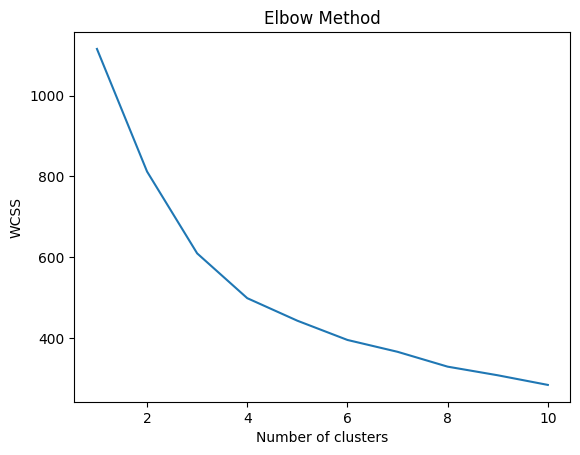

In [20]:
# Calculate WCSS for different values of k
wcss = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
# Define the agglomerative clustering algorithm
agg_clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0)

# Fit the model
agg_clustering.fit(scaled_data)

X_pd = pd.DataFrame(scaled_data)

# Group the data by cluster labels
groups = X_pd.groupby(agg_clustering.labels_)

# Calculate the mean or median of each feature within each group
means = groups.mean()
medians = groups.median()

# Print the mean or median of each feature within each group
print("Means:")
print(means)
print("Medians:")
print(medians)

Means:
            0         1         2         3    4         5         6
0    1.678864 -0.114040 -0.694225  1.922128  0.0  1.742054  2.104556
1    1.678864 -0.114040 -0.694225  1.922128  0.0  1.742054  2.104556
2   -0.597310  0.483466 -0.144213 -0.686107  0.0 -0.223448 -0.870527
3   -0.629369  0.529428 -0.546145 -0.671681  0.0 -0.658567 -0.902148
4   -1.094222  0.345580 -0.630763 -1.139086  0.0  0.913195  1.110503
..        ...       ...       ...       ...  ...       ...       ...
181 -1.350692 -0.826451 -0.799997 -1.245839  0.0  0.007371 -1.059386
182 -0.020252  0.598371  0.490416 -0.163883  0.0 -0.586008 -0.073770
183  1.262099 -0.826451 -0.398065  1.521083  0.0 -0.553378  0.053335
184 -1.158339 -0.918375 -0.842306 -1.020792  0.0  0.025683 -1.079704
185  1.823128  1.057990  1.759675  1.596098  0.0  0.104913 -1.200442

[186 rows x 7 columns]
Medians:
            0         1         2         3    4         5         6
0    1.678864 -0.114040 -0.694225  1.922128  0.0  1.742054  2.1

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


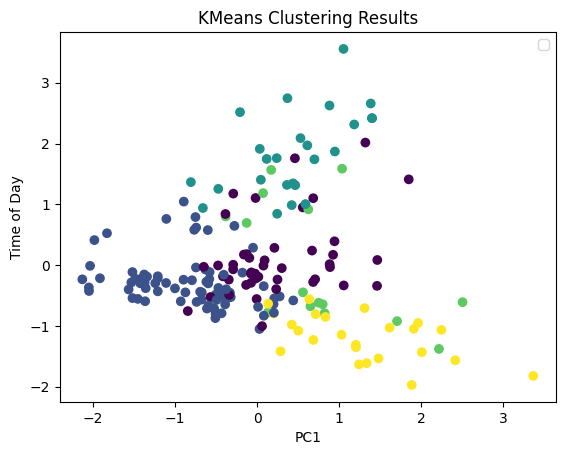

In [22]:
# Step 1: Separate the target variable from the features
target_variable = df_events['peak_time_of_day'].values.reshape(-1, 1)

# Step 3: Apply PCA to the features data
pca = PCA(n_components=4, random_state=42)
pca_components = pca.fit_transform(scaled_data)

# Step 4: Concatenate the PCA components with the target variable
data = np.concatenate((pca_components, target_variable), axis=1)

# Step 5: Normalize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Step 6: Apply KMeans clustering to the concatenated data
kmeans = KMeans(n_clusters=5)
kmeans.fit(data_scaled)

# Define the data source for the scatter plot
source = ColumnDataSource(data=dict(
    x=data_scaled[:, 0],
    y=data_scaled[:, 1],
    desc=df_events.index.tolist()
))

# Define the hover tooltip
hover = HoverTool(tooltips=[('event', '@desc')])

# Create the scatter plot
p = figure(title='KMeans Clustering Results', tools=[hover])
p.scatter('x', 'y', source=source)

# Show the scatter plot
show(p)

# Step 7: Plot the clustering results
plt.scatter(data_scaled[:, 0], data_scaled[:, 1], c=kmeans.labels_)
plt.xlabel('PC1')
plt.ylabel('Time of Day')
plt.title('KMeans Clustering Results')
plt.legend()
plt.show()#

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


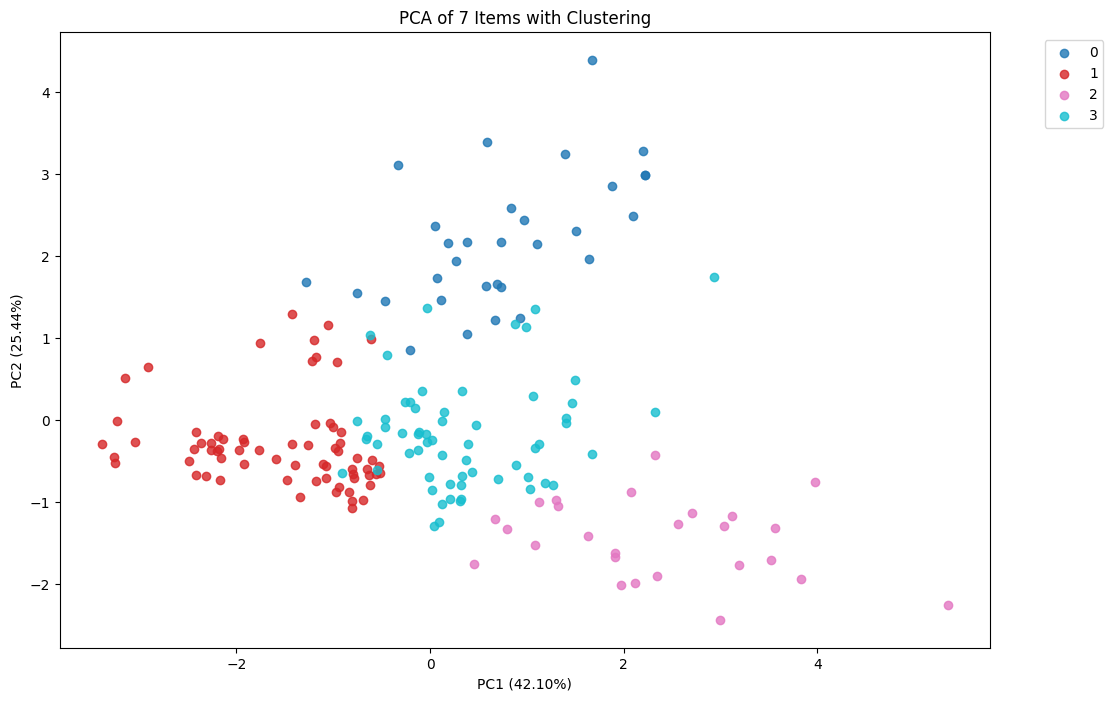

In [31]:
# Select the columns for clustering
columns_for_clustering = ['peak_glucose', 'glucose_rise', 'glucose_drop', 'positive_iAUC', 'negative_iAUC', 'ROA', 'ROD']

# Separate the target variable from the features
target_variable = df_events['peak_time_of_day'].values.reshape(-1, 1)

# Create a DataFrame with only the selected columns (replace df_events with your actual DataFrame)
df_scaled = df_events[columns_for_clustering].copy()

# Scale the data using StandardScaler
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_scaled)

# Perform PCA
pca = PCA(n_components=2, random_state=42)
X_r = pca.fit_transform(scaled_data)

# Perform clustering on the original data along with the target variable
kmeans = KMeans(n_clusters=4, random_state=42)
predictions = kmeans.fit_predict(np.concatenate((scaled_data, target_variable), axis=1))

plt.figure(figsize=(12, 8))
num_clusters = 4

colors = plt.cm.get_cmap('tab10', num_clusters)

for i in range(num_clusters):
    cluster_indices = np.where(predictions == i)[0]
    plt.scatter(X_r[cluster_indices, 0], X_r[cluster_indices, 1], color=colors(i), alpha=0.8, label=i)

plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.6)
plt.xlabel('PC1 ({:.2f}%)'.format(pca.explained_variance_ratio_[0] * 100))
plt.ylabel('PC2 ({:.2f}%)'.format(pca.explained_variance_ratio_[1] * 100))
plt.title('PCA of 7 Items with Clustering')
plt.show()

0      3
1      0
2      2
3      0
4      3
      ..
181    3
182   -1
183    0
184   -1
185   -1
Name: cluster_label, Length: 186, dtype: int64


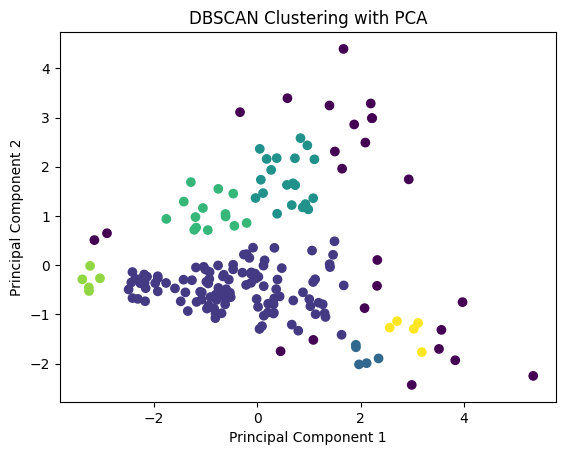

In [27]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Apply PCA on the scaled data
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

# Run DBSCAN clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(pca_data)

# Assign cluster labels to the DataFrame
df_events['cluster_label'] = clusters

# Print the cluster labels
print(df_events['cluster_label'])

# Visualize the clusters after PCA
plt.scatter(pca_data[:, 0], pca_data[:, 1], c=clusters, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('DBSCAN Clustering with PCA')
plt.show()